In [1]:
import pandas as pd
import numpy as np
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise import NormalPredictor
import matplotlib.pyplot as plt
import datetime
import os

# Load data
data = pd.read_csv("data/full_data_cleaned.csv")

In [2]:
#Define Reader with rating scale
reader = Reader(rating_scale=(1, 5))
#Load data into surprise dataset
df = Dataset.load_from_df(data[['author_id','product_id','rating_x']], reader)


## Build Baseline model Stochastic Gradient Descent (SGD)

In [3]:
#Build Baseline model Stochastic Gradient Descent (SGD)
param_grid = {'bsl_options': {'method': ['sgd'],  
                               'reg': [0.01, 0.05, 0.1, 0.2],
                               'learning_rate': [0.001, 0.005, 0.01, 0.05],
                               'n_epochs': [5, 10, 20, 50]}
             }

GS = GridSearchCV(BaselineOnly, 
                  param_grid, 
                  measures=['rmse', 'mae', 'fcp'], 
                  cv=KFold(n_splits=5, random_state=2024))

#Fit the model
GS.fit(df)               

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

In [4]:
# Convert list of parameters to DataFrame
results_df = pd.DataFrame(GS.cv_results['params'])

# Add new columns to the dataframe
results_df['rmse'] = GS.cv_results['mean_test_rmse']
results_df['mae'] = GS.cv_results['mean_test_mae']
results_df['fcp'] = GS.cv_results['mean_test_fcp']

# View result dataframe
results_df = pd.concat([results_df.drop(['bsl_options'], axis=1), results_df['bsl_options'].apply(pd.Series)], axis=1)


# save data to local folder
results_df.to_csv(path_or_buf='../data/SGD_CV_hyperparam_result.csv', index=False)

results_df

,rmse,mae,fcp,method,reg,learning_rate,n_epochs
0,1.011092,0.765627,0.516859,sgd,0.01,0.001,5
1,1.002744,0.753773,0.518207,sgd,0.01,0.001,10
2,0.991963,0.740529,0.519373,sgd,0.01,0.001,20
3,0.970994,0.717304,0.519445,sgd,0.01,0.001,50
4,0.988620,0.738832,0.515805,sgd,0.01,0.005,5
...,...,...,...,...,...,...,...
59,0.923660,0.645179,0.517272,sgd,0.20,0.010,50
60,0.938886,0.678718,0.510329,sgd,0.20,0.050,5
61,0.932398,0.655133,0.511290,sgd,0.20,0.050,10
62,0.938746,0.640344,0.512174,sgd,0.20,0.050,20


In [5]:

#print the best parameters
#RMSE
print('Best RMSE:', GS.best_score['rmse'])
print('Best parameteres for RMSE:', GS.best_params['rmse'])
#MAE
print('Best mae:', GS.best_score['mae'])
print('Best parameteres for MAE:', GS.best_params['mae'])
#FCP
print('Best ranking (FCP):', GS.best_score['fcp'])
print('Best parameters for ranking (FCP):', GS.best_params['fcp']) 
#Fit time
min_time = np.argmin(GS.cv_results['mean_fit_time'])
print('Best Fit time:', GS.cv_results['mean_fit_time'][min_time])
print('Best parameteres for Fit time:', GS.cv_results['params'][min_time])

Best RMSE: 0.9236598154539042
Best parameteres for RMSE: {'bsl_options': {'method': 'sgd', 'reg': 0.2, 'learning_rate': 0.01, 'n_epochs': 50}}
Best mae: 0.6202308772352829
Best parameteres for MAE: {'bsl_options': {'method': 'sgd', 'reg': 0.01, 'learning_rate': 0.05, 'n_epochs': 50}}
Best ranking (FCP): 0.5197210698061477
Best parameters for ranking (FCP): {'bsl_options': {'method': 'sgd', 'reg': 0.05, 'learning_rate': 0.001, 'n_epochs': 50}}
Best Fit time: 0.8169117927551269
Best parameteres for Fit time: {'bsl_options': {'method': 'sgd', 'reg': 0.2, 'learning_rate': 0.01, 'n_epochs': 5}}


In [6]:
# Extract row for best sets of hyperparameters
best_params_df_baseline = results_df.query(
    "(reg == 0.01 & learning_rate == 0.05 & n_epochs == 50) or "
    "(reg == 0.05 & learning_rate == 0.005 & n_epochs == 50) or "
    "(reg == 0.2 & learning_rate == 0.001 & n_epochs == 50)"
)

best_params_df_baseline.loc[:, 'set']=[1,2,3]
# convert to long format
best_params_df_baseline_long = best_params_df_baseline[['rmse','mae','fcp','set']].melt('set', var_name='metric', value_name='values')
# Display DataFrame
best_params_df_baseline_long

C:\Users\dtvut\AppData\Local\Temp\ipykernel_18700\3090211378.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_params_df_baseline.loc[:, 'set']=[1,2,3]


,set,metric,values
0,1,rmse,0.970211
1,2,rmse,0.927357
2,3,rmse,0.971950
3,1,mae,0.620231
4,2,mae,0.659796
5,3,mae,0.723501
6,1,fcp,0.518055
7,2,fcp,0.518751
8,3,fcp,0.519634


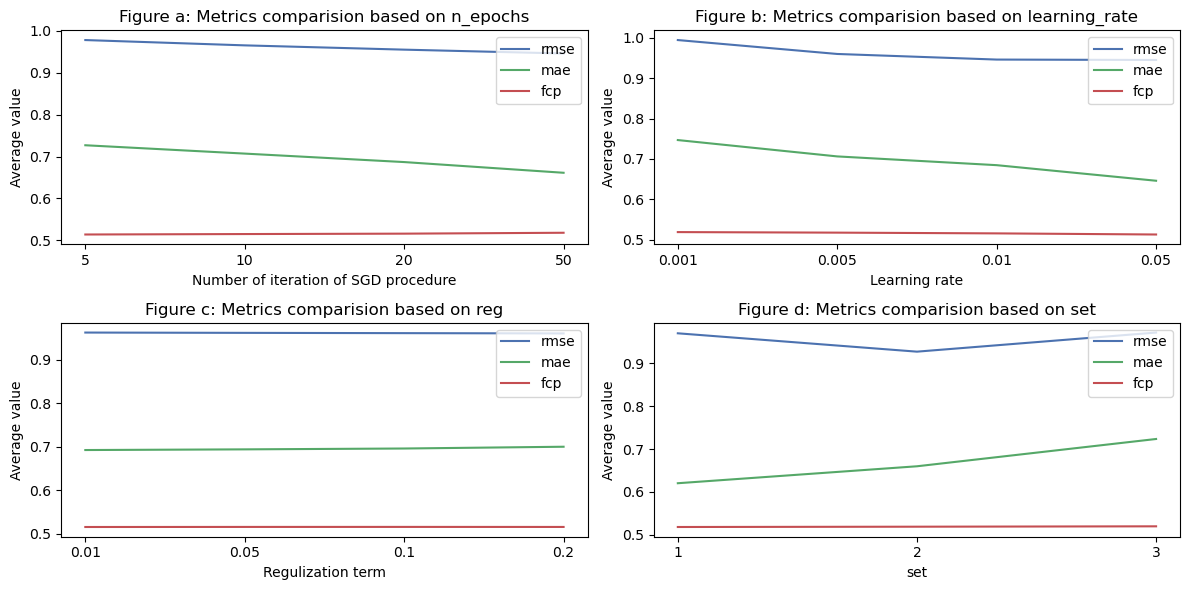

In [7]:
# write a function to calculate the average of cross-validation evaluation metrics
# and convert the dataframe from wide to long format for further plotting
def results_sum_func(param):
    grouped_df = results_df.groupby(param)[['rmse', 'mae', 'fcp']].mean()
    grouped_df_long = grouped_df.reset_index().melt(param, var_name='metric', value_name='values')
    return grouped_df_long
# run function for parameters
grouped_results_df1 = results_sum_func('n_epochs')
grouped_results_df2 = results_sum_func('learning_rate')
grouped_results_df3 = results_sum_func('reg')

# create function to draw each subplot
def subplot_func(long_df, param, ax, fig_num, xlabel, ylabel):
    # Convert parameter column to string for better display of comparision on plot
    long_df[param] = long_df[param].astype(str)
    # Plot lines
    for metric in long_df['metric'].unique():
        data = long_df[long_df['metric'] == metric]
        ax.plot(data[param], data['values'], label=f'{metric}')
    # Set title and labels
    ax.set_title('Figure '+fig_num+': '+'Metrics comparision based on'+' '+param)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Add legend to the plot
    ax.legend(loc = 'upper right')

plt.style.use("seaborn-v0_8-deep")
# Create structure for the big plot
fig, ax = plt.subplots(2,2, figsize=(12, 6))

## Subplot 1

subplot_func(grouped_results_df1, 'n_epochs', ax[0,0], 
             'a', 'Number of iteration of SGD procedure', 'Average value')

## Subplot 2
subplot_func(grouped_results_df2, 'learning_rate', ax[0,1], 
             'b', 'Learning rate', 'Average value')

## Subplot 3
subplot_func(grouped_results_df3, 'reg', ax[1,0], 
             'c', 'Regulization term', 'Average value')

## Subplot 3
subplot_func(best_params_df_baseline_long, 'set', ax[1,1], 
             'd', 'set', 'Average value')

plt.tight_layout()  # Adjust the layout to prevent overlaps
plt.savefig('../picture/CF_model_SGD.png', dpi=900)
plt.show()

## Build Random model

In [8]:
# Set the random seed
np.random.seed(2024)

#Build Random model
Random = cross_validate(NormalPredictor(), 
                        df,
                        measures=['RMSE', 'MAE', 'FCP'], 
                        cv=KFold(n_splits=5, random_state=2024), 
                        verbose=True)

# Print results
print("RMSE:", Random['test_rmse'].mean())
print("MAE:", Random['test_mae'].mean())
print("FCP:", Random['test_fcp'].mean())
print("Fit time:", np.mean(list(Random['fit_time'])))

# RMSE: 1.3333265468095647
# MAE: 0.971076300223638
# FCP: 0.49232186902000186
# Fit time: 0.42636637687683104

Evaluating RMSE, MAE, FCP of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3344  1.3348  1.3312  1.3273  1.3353  1.3326  0.0030  
MAE (testset)     0.9717  0.9726  0.9689  0.9667  0.9733  0.9706  0.0025  
FCP (testset)     0.4971  0.4918  0.4814  0.4868  0.4827  0.4880  0.0058  
Fit time          0.47    0.63    0.62    0.67    0.64    0.61    0.07    
Test time         0.57    0.58    0.74    0.75    0.78    0.68    0.09    
RMSE: 1.332611387714005
MAE: 0.9706418498370946
FCP: 0.4879665379525767
Fit time: 0.6055262088775635


### Model with best parameter

In [9]:
# Best RMSE: 0.9256489830130615
# Best parameteres for RMSE: {'bsl_options': {'method': 'sgd', 'reg': 0.2, 'learning_rate': 0.01, 'n_epochs': 50}}
# Best mae: 0.6270702366177469
# Best parameteres for MAE: {'bsl_options': {'method': 'sgd', 'reg': 0.01, 'learning_rate': 0.05, 'n_epochs': 50}}
# Best ranking (FCP): 0.5241780801308998
# Best parameters for ranking (FCP): {'bsl_options': {'method': 'sgd', 'reg': 0.01, 'learning_rate': 0.05, 'n_epochs': 50}}
# Best Fit time: 0.4838540554046631
# Best parameteres for Fit time: {'bsl_options': {'method': 'sgd', 'reg': 0.2, 'learning_rate': 0.005, 'n_epochs': 5}}

#fit SGD model with best parameters
Bsl_options = {'method': 'sgd', 'reg': 0.01, 'learning_rate': 0.05, 'n_epochs': 50}
Baseline = BaselineOnly(bsl_options=Bsl_options)

#Train the model
trainset = df.build_full_trainset()
Baseline.fit(trainset)

Estimating biases using sgd...


In [10]:
#function to get top n recommendations for a user
def get_top_n_recommendations(model, user_id, n=10, df = data):
    #set of unique product ids
    products = df.product_id.unique()
    #predict ratings for all products for the user
    predictions = [model.predict(user_id, product_id) for product_id in products]
    #sort the predictions
    predictions.sort(key=lambda x: x.est, reverse=True)
    #Top n predictions
    Top_n = [pred.iid for pred in predictions[:n]]
    #Create a dataframe of top n recommendations with product information
    Recommendations = []
    for product_id in Top_n:
        product_info = df[df.product_id == product_id]
        Recommendations.append({
            'product_name': product_info.iloc[0].product_name_x,
            'product_id': product_info.iloc[0].product_id,
            'brand': product_info.iloc[0].brand_name_x,
            'limited_edition': product_info.iloc[0].limited_edition,
            'price': product_info.iloc[0].price_usd_x,
            'rating': product_info.rating_x.mean(),

        })
    return pd.DataFrame(Recommendations).sort_values(by='rating', ascending=False)

get_top_n_recommendations(Baseline, 1238130325, 5, data)

,product_name,product_id,brand,limited_edition,price,rating
0,Capture Totale Intensive Night Restorative Crème,P375354,Dior,0,175.0,5.000000
3,ELEVATE Advanced Retinol Serum,P433469,Algenist,0,98.0,5.000000
1,Plantscription SPF 25 Power Anti-Aging Oil-Fre...,P409816,Origins,0,73.0,4.750000
4,Dermatologist Solutions Centella Sensitive Cic...,P436378,Kiehl's Since 1851,0,46.0,4.666667
2,Resilience Multi-Effect Night Tri-Peptide Face...,P422649,Estée Lauder,0,110.0,4.200000
